# Sound Classification for behaviour analysis.

In this notebook, ten different types of sounds are used to create a classifier capable to classify these sounds. The purpose of creating this model is to help identify anti-social and criminal behaviour from sound clips. In this notebook, we will first do some important EDA on these sounds to know what we are dealing with. After this we will be extracting features from these sound waves and perform some preprecessing techniques to createa dataset that we can use to train our model. We will try to use various models and hyper parameters to obtain the best results.

## EDA - Exploratory data analysis:

In [16]:
#Import important libraries
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

The metadata for these sound clips is also available which provide us with a lot of information related to our audio signals and can be used for the EDA. For this purpose, we will import the CSV file containing the metadata into a pandas dataframe to visualize it properly. After this, we can see the number of files, various classses, salience and start and end points of the individual clips from the original clip, as the audios available are are clippings from longer audios.

In [17]:
# Import the CSV file in pandas dataframe

In [18]:
df = pd.read_csv('./UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The shape of the folder tells us that there are total 8732 audio files present in the dataset.

In [19]:
df.shape

(8732, 8)

There are 5702 files with salience value of 1, while the remaining 3030 files have salience value of 2. The files with salience 1 are present in the foreground channel and the others are in the background channel.

In [20]:
df['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

We can also observe that the data is already labeled and Class IDs are assigned to the 10 classes as shown below.

In [21]:
cls_df = df.groupby(['class', 'classID']).nunique()
cls_df.iloc[:, :0]

,
class,classID
air_conditioner,0
car_horn,1
children_playing,2
dog_bark,3
drilling,4
engine_idling,5
gun_shot,6
jackhammer,7
siren,8


The fsID will tell us about the original files. The fsIDs are the base files from whcih the short clips are derived. The total count of fsID column is 1297, which means that there are 1297 main files from which the other files are taken out.

In [22]:
df['fsID'].value_counts()

24347     100
180937     95
72259      73
203929     72
62837      66
         ... 
196065      1
196064      1
196062      1
196061      1
100032      1
Name: fsID, Length: 1297, dtype: int64

To check the imbalnce in the data, we need to see the number of instances present for each class type. It is observable that all the classes have 1000 instances excepth the sciren, car horn and gun shot. After we split the data we will check the values again and if there is any imbalance in the training set, we can balance  it by using smote on the extracted features. A graphical representation of the distribution is also provided below

In [23]:
count=df['class'].value_counts()
Dist=pd.DataFrame({'Class Label':list(count.keys()),
                   'Instances':list(count)})
Dist

,Class Label,Instances
0,dog_bark,1000
1,children_playing,1000
2,air_conditioner,1000
3,street_music,1000
4,engine_idling,1000
5,jackhammer,1000
6,drilling,1000
7,siren,929
8,car_horn,429
9,gun_shot,374


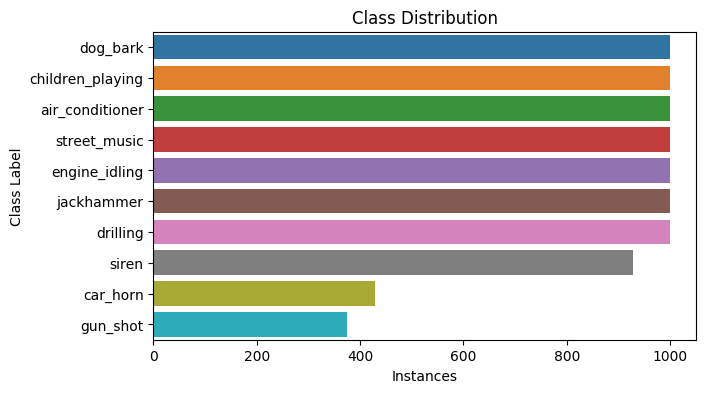

In [39]:
plt.figure(figsize=(7, 4))
plt.title('Class Distribution')
sns.barplot(x=Dist['Instances'],
           y=Dist['Class Label']);
plt.show()

### Signal observation

After having a birds eye view of the datset, we need to go ahead and check the actual file and see how the signals look like. We will be taking one of the files (first one, barking dog) to observe the time domain signal created by this file.

In [99]:
filename='./audio/fold5/100032-3-0-0.wav'

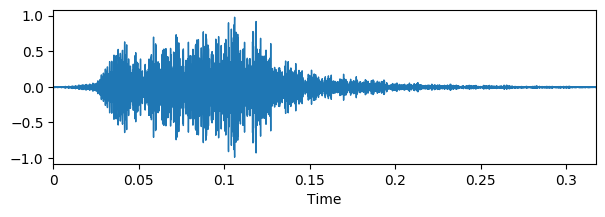

In [100]:
plt.figure(figsize=(7,2))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)
plt.show()

A key thing to note is that we have used librosa here to read the audio siganl. The sample rate that librosa uses to sample the signals is 22050 by default. If we use wav.read instead of librosa, the sameple rate will be different.

In [101]:
sample_rate

22050

In [102]:
wave_sample_rate, wave_audio=wav.read(filename)

In [103]:
wave_sample_rate

44100

Also as we discussed earlier, there are two channels in the signal, foreground and background, we can view both of them. Librosa tends to combine both the channels and create a singal audio signal and we will be interested in using signal as created by librosa here.

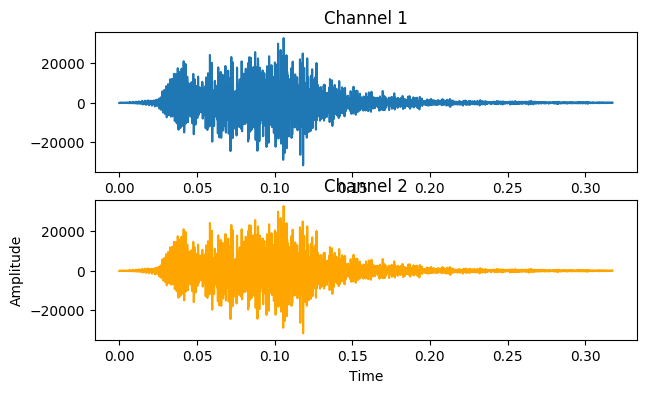

In [104]:
fig, axs = plt.subplots(2)
fig.set_figheight(4)
fig.set_figwidth(7)

length = wave_audio.shape[0] / wave_sample_rate
time = np.linspace(0., length, wave_audio.shape[0])
axs[0].plot(time,wave_audio[:,0])
axs[1].plot(time,wave_audio[:,1],color='orange')

plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.xlabel("Time")
plt.ylabel("Amplitude")

axs[0].set_title('Channel 1')
axs[1].set_title('Channel 2')
plt.show()

After observing the time domain signal, we can also have a look at the Frequency domain aswell using a fast fourier transform. These are helpful as every class has a different frequency and can be helpful in training the model. The other thing that we can get from the FFT is the cepstrum of the audio signal. For the ease of observation, we can also plot these as given below. More on the frequency domain signals and cepstrum will be discussed in the feature extracion part.

In [105]:
# Creating power spectrum (FFT)
X_fft = np.fft.fft(data)
X_spec = (np.absolute(X_fft))
f = np.linspace(0, sample_rate, len(X_spec))
f_bins = int(len(X_spec)*10) 

# Creating cepstrum (IFFT)
X_ifft = np.fft.ifft(X_spec)
X_ceps = np.absolute(X_ifft)
q = np.linspace(0, sample_rate/1000, len(X_ceps))

Text(0, 0.5, 'Magnitude')

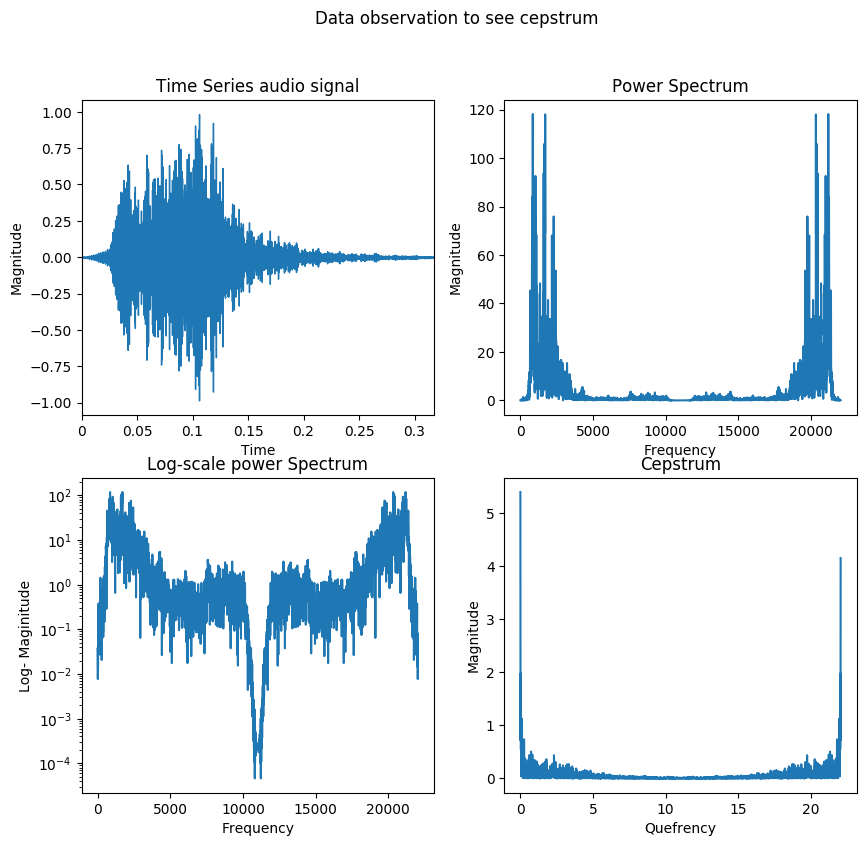

In [108]:

# Plotting using subplots
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False)
fig.set_figheight(9)
fig.set_figwidth(10)

# Plots
librosa.display.waveplot(data, sr = sample_rate, ax=ax[0, 0]) 
ax[0, 1].plot(f[:f_bins], X_spec[:f_bins])
ax[1, 0].plot(f[:f_bins], X_spec[:f_bins])
ax[1, 0].set_yscale("log")
ax[1, 1].plot(q, X_ceps)

# Titles
fig.suptitle('Data observation to see cepstrum')
ax[0, 0].set_title('Time Series audio signal')
ax[0, 1].set_title('Power Spectrum')
ax[1, 0].set_title('Log-scale power Spectrum')
ax[1, 1].set_title('Cepstrum')

# Labels
ax[0, 1].set_xlabel('Frequency')
ax[1, 0].set_xlabel('Frequency')
ax[1, 1].set_xlabel('Quefrency')
ax[0, 0].set_ylabel('Magnitude')
ax[0, 1].set_ylabel('Magnitude')
ax[1, 0].set_ylabel('Log- Maginitude')
ax[1, 1].set_ylabel('Magnitude')